# Switzerland Road Traffic Accidents Forecasting

In this notebook we will try to forecast road traffic accidents in switzerland using the "Strassenverkehrsunfallorte" dataset available at the following address: https://opendata.swiss/en/dataset/strassenverkehrsunfalle-mit-personenschaden

__Planned Work__: 
- Accidents localisation visualization.
- Accidents number forecasting for 2019
- Accidents number forecasting for 2018 to check that it matches with reality (TBD)
- Accidents with fatalities analysis

__Dataset Description:__ Anonymised visualisation and positioning of road traffic accidents with injury to persons since 2011. Information on the year, the month, the weekday, the time of the accident, the type of road, the type of accident and the category of severity is provided for road traffic accidents.

## Importation of libraries

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import datashader as ds
import datashader.transfer_functions as tf
from datetime import datetime
from colorcet import fire
from matplotlib.colors import rgb2hex
from matplotlib.cm import get_cmap
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
import plotly.offline as py
# from __future__ import absolute_import, division, print_function, unicode_literals

from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM, CuDNNLSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import ConvLSTM2D
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error




Using TensorFlow backend.


# Data loading and cleaning
We load the dataset and basic cleaning of the data:
- replace the nan values by doing a forward fill
- keeping only relevant columns for our work

In [2]:
df = pd.read_csv('RoadTrafficAccidentLocations.csv')
df.head()
df = df.fillna(method='ffill')

In [3]:
original_columns = df.columns
columns2keep = ['AccidentUID', 'AccidentType', 'AccidentType_en',
                'AccidentSeverityCategory', 'AccidentSeverityCategory_en',
                'AccidentInvolvingPedestrian', 'AccidentInvolvingBicycle',
                'AccidentInvolvingMotorcycle', 'RoadType', 'RoadType_en',
                'AccidentLocation_CHLV95_E', 'AccidentLocation_CHLV95_N',
                'CantonCode', 'MunicipalityCode', 'AccidentYear',
                'AccidentMonth', 'AccidentMonth_en', 'AccidentWeekDay',
                'AccidentWeekDay_en', 'AccidentHour', 'AccidentHour_text']
df = df[columns2keep]
df['AccidentType'] = df.AccidentType.astype('category')
df['AccidentWeekDay'] = df['AccidentWeekDay'].str[-1:].astype(int)
df.head(2)

,AccidentUID,AccidentType,AccidentType_en,AccidentSeverityCategory,AccidentSeverityCategory_en,AccidentInvolvingPedestrian,AccidentInvolvingBicycle,AccidentInvolvingMotorcycle,RoadType,RoadType_en,...,AccidentLocation_CHLV95_N,CantonCode,MunicipalityCode,AccidentYear,AccidentMonth,AccidentMonth_en,AccidentWeekDay,AccidentWeekDay_en,AccidentHour,AccidentHour_text
0,9FD6441F802C20A6E0430A865E3320A6,at0,Accident with skidding or self-accident,as3,Accident with light injuries,False,True,False,rt433,Minor road,...,1246980,ZH,261,2011,1,January,6,Saturday,1.0,01h-02h
1,99AE7B25356510B0E0430A865E3310B0,at4,Accident when turning-into main road,as3,Accident with light injuries,False,False,True,rt433,Minor road,...,1117371,GE,6621,2011,1,January,6,Saturday,1.0,01h-02h


# Transforming the dataset into a timeseries
## Obtaining the missing day number of the month:
The original dataset misses an important column: The day number of the month !
We have the year, the month, the day (monday, tuesday, ...) but not the number which is a bit weird ...
Therefore, assuming that the dataset index is ordered in time and that there is at least one accident per day, we will try to reconstruct it.

I have done some unit tests by checking that the corrsponding day number reconstructed matches with the day corresponding to the date of interest. Unfortunately those unit tests are a necessary condition but not sufficient ...

In [4]:
groups = df.groupby(['AccidentYear', 'AccidentMonth', 'AccidentWeekDay'])

# The goal is to check when the day as well as the month are changing.
df['day_change'] = np.append(0, np.diff(df.AccidentWeekDay)) # We need to add the last value
df['month_change'] = np.append(0, np.diff(df.AccidentMonth)) # We need to add the last value
df[['month_change', 'day_change']]

df['AccidentDay'] = 1
n_day = []  # List containing the day numbers of each row in the dataframe
for index in range(len(df)):
    if index == 0:
        n_day.append(1)
    elif df['month_change'].values[index] != 0:
        n_day.append(1) # If month changing we start back at the 1st of the month
    elif df['day_change'].values[index] != 0:
        n_day.append(n_day[-1] +1 ) # If the day is changing we increment the number
    else:
        n_day.append(n_day[-1])  # If not we keep the same day number 
df['AccidentDay'] = np.array(n_day, dtype=np.int)


## Timeseries transformation

In [5]:
df.AccidentHour.isna().sum()
df['Year'] = df.AccidentYear.astype('str')
df['Month'] = df.AccidentMonth.astype('str')
df['Day'] = df.AccidentDay.astype('str')
df['AccidentHour'] = df.AccidentHour.astype(int)
df['Hour'] = df.AccidentHour.astype('str')

df['timestamp'] = df.Year + ' ' + df.Month + ' ' + df.Day + ' ' + df.Hour
df['timestamp'] = df['timestamp'].apply(lambda x: datetime.strptime(x, '%Y %m %d %H'))

df = df.set_index('timestamp')


# Counting the number of accident per hour:
Now we want to know for each hour we have in our dataset, how many accidents occured in Switzerland

,n_accident
count,2923.000000
mean,49.113582
std,15.900145
min,7.000000
25%,38.000000
50%,48.000000
75%,59.000000
max,108.000000


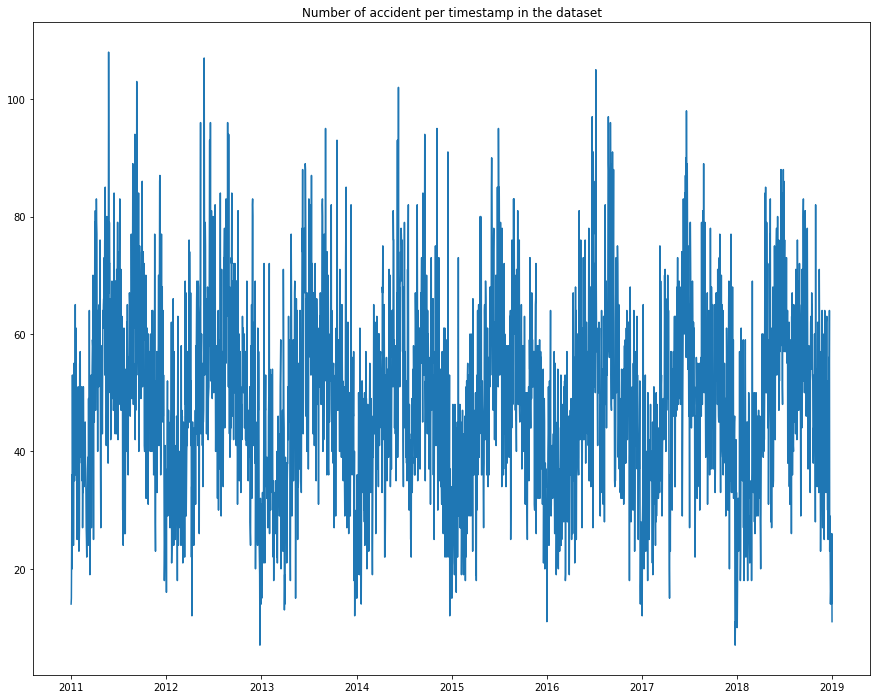

In [6]:
def get_df_count(df, dt=None, en_plot=False):
    if dt is not None:
        df = df.reset_index()
        df.timestamp =  df.timestamp.dt.round(dt)
        df = df.set_index('timestamp')
    df_count = pd.DataFrame()
    df_count['n_accident'] = df.groupby('timestamp').AccidentUID.count()
    if en_plot:
        plt.figure(figsize=(15, 12))
        plt.plot(df_count['n_accident'])
        plt.title('Number of accident per timestamp in the dataset')
    return df_count

df_count = get_df_count(df, dt='1D', en_plot=True)
df_count.describe()


It is very difficult to extract any usefull information from this plot, we will therefore use the prophet toolbox.

# Number of accident forecasting using LSTM

## Transforming the dataset into a supervised one:
To do so I took the function available on machine learning mistery: https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
It frames our timeseries into multiple rows where each column is a detla time with respect to the timestamp where you start your prediction

In [7]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

### Problem shaping:
For our problem we will try to predict the number of daily accidents for the next 365 days using the last 1000 observations:
We will train our model using the measurements until the year 2017 included and then test our prediction on the year 2018 to compare with the facebook Prophet estimations done in another notebook

In [8]:
n_lags = 1000  # Number of past measurement used for prediction
n_predict = 365  # Number of prediction steps
features2use = ['n_accident']
feature2predict = ['n_accident']
percentage_train = 0.7  # Percentage of the train set

# Reorganisation of the data
n_len = n_lags + n_predict
n_features = len(features2use)
n_feature_pred = len(feature2predict)
n_obs = n_lags * n_features
n_tot_preds = n_feature_pred*n_predict

data2forecast = series_to_supervised(df_count.loc['2011':'2017'].values,n_lags,n_predict)
data2forecast_test = series_to_supervised(df_count.values,n_lags,n_predict).tail(1)

## Normalization of our values:
Normalization should not be mandatory for ourn 

In [9]:
ratio = 1000
data_scaled = data2forecast.values / ratio 
data_scaled_test = data2forecast.values / ratio  

In [10]:
np.random.shuffle(data_scaled)

In [11]:
n_train = int(len(data_scaled)*percentage_train)
train = data_scaled[:, :]
test = data_scaled_test[-1:, :]

In [12]:
train_X, train_Y = train[:, :n_obs], train[:, -n_tot_preds:]

train_Yb = train[:, -n_predict*n_features:]  # Incl the clmns we don't predict
for i in range(n_feature_pred):
    train_Y[:, i::n_feature_pred] = train_Yb[:, i::n_features]

test_X, test_Y = test[:, :n_obs], test[:, -n_tot_preds:]
test_Yb = test[:, -n_predict*n_features:]  # Incl the clmns we don't predict
for i in range(n_feature_pred):
    test_Y[:, i::n_feature_pred] = test_Yb[:, i::n_features]

In [13]:
print(train_X.shape, len(train_X), train_Y.shape)


(1193, 1000) 1193 (1193, 365)


In [14]:
train_X = train_X.reshape((train_X.shape[0], n_lags, n_features))
test_X = test_X.reshape((test_X.shape[0], n_lags, n_features))
print(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape)

(1193, 1000, 1) (1193, 365) (1, 1000, 1) (1, 365)


In [23]:
from keras.backend.tensorflow_backend import set_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import get_session
import tensorflow

sess = get_session()
clear_session()
sess.close()
sess = get_session()

In [24]:
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint

model = Sequential()
model.add(CuDNNLSTM(200, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(n_predict*n_feature_pred))
model.compile(loss='mse', optimizer='nadam',  metrics=['mse'])
# simple early stopping
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, )
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
print(model.summary())
# fit network
history = model.fit(train_X, train_Y, epochs=300,
                    batch_size=512, validation_split=0.33,
                    verbose=2, shuffle=False, callbacks=[mc])
# plot history


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, 200)               162400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 365)               73365     
Total params: 235,765
Trainable params: 235,765
Non-trainable params: 0
_________________________________________________________________
None


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x000001B473414278>>
Traceback (most recent call last):
  File "C:\Users\figu\AppData\Local\conda\conda\envs\crm_env_36\lib\site-packages\tensorflow\python\client\session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "C:\Users\figu\AppData\Local\conda\conda\envs\crm_env_36\lib\site-packages\tensorflow\python\framework\errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 799 samples, validate on 394 samples
Epoch 1/300
 - 2s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0016 - val_mean_squared_error: 0.0016

Epoch 00001: val_loss improved from inf to 0.00159, saving model to best_model.h5
Epoch 2/300
 - 1s - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0015 - val_mean_squared_error: 0.0015

Epoch 00002: val_loss improved from 0.00159 to 0.00146, saving model to best_model.h5
Epoch 3/300
 - 1s - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 6.2923e-04 - val_mean_squared_error: 6.2923e-04

Epoch 00003: val_loss improved from 0.00146 to 0.00063, saving model to best_model.h5
Epoch 4/300
 - 1s - loss: 7.3671e-04 - mean_squared_error: 7.3671e-04 - val_loss: 3.7182e-04 - val_mean_squared_error: 3.7182e-04

Epoch 00004: val_loss improved from 0.00063 to 0.00037, saving model to best_model.h5
Epoch 5/300
 - 1s - loss: 5.3736e-04 - mean_squared_error: 5.3736e-04 - val_loss: 3.3829e-04 - val_mean_squared_error: 3.3829e-04



Epoch 00042: val_loss did not improve from 0.00024
Epoch 43/300
 - 1s - loss: 2.5793e-04 - mean_squared_error: 2.5793e-04 - val_loss: 2.4680e-04 - val_mean_squared_error: 2.4680e-04

Epoch 00043: val_loss did not improve from 0.00024
Epoch 44/300
 - 1s - loss: 2.5677e-04 - mean_squared_error: 2.5677e-04 - val_loss: 2.4632e-04 - val_mean_squared_error: 2.4632e-04

Epoch 00044: val_loss did not improve from 0.00024
Epoch 45/300
 - 1s - loss: 2.5543e-04 - mean_squared_error: 2.5543e-04 - val_loss: 2.4529e-04 - val_mean_squared_error: 2.4529e-04

Epoch 00045: val_loss did not improve from 0.00024
Epoch 46/300
 - 1s - loss: 2.5433e-04 - mean_squared_error: 2.5433e-04 - val_loss: 2.4317e-04 - val_mean_squared_error: 2.4317e-04

Epoch 00046: val_loss did not improve from 0.00024
Epoch 47/300
 - 1s - loss: 2.5283e-04 - mean_squared_error: 2.5283e-04 - val_loss: 2.4215e-04 - val_mean_squared_error: 2.4215e-04

Epoch 00047: val_loss did not improve from 0.00024
Epoch 48/300
 - 1s - loss: 2.5099


Epoch 00084: val_loss did not improve from 0.00023
Epoch 85/300
 - 2s - loss: 2.3880e-04 - mean_squared_error: 2.3880e-04 - val_loss: 2.3556e-04 - val_mean_squared_error: 2.3556e-04

Epoch 00085: val_loss did not improve from 0.00023
Epoch 86/300
 - 2s - loss: 2.3812e-04 - mean_squared_error: 2.3812e-04 - val_loss: 2.3548e-04 - val_mean_squared_error: 2.3548e-04

Epoch 00086: val_loss did not improve from 0.00023
Epoch 87/300
 - 2s - loss: 2.3811e-04 - mean_squared_error: 2.3811e-04 - val_loss: 2.3539e-04 - val_mean_squared_error: 2.3539e-04

Epoch 00087: val_loss did not improve from 0.00023
Epoch 88/300
 - 2s - loss: 2.3796e-04 - mean_squared_error: 2.3796e-04 - val_loss: 2.3543e-04 - val_mean_squared_error: 2.3543e-04

Epoch 00088: val_loss did not improve from 0.00023
Epoch 89/300
 - 2s - loss: 2.3776e-04 - mean_squared_error: 2.3776e-04 - val_loss: 2.3525e-04 - val_mean_squared_error: 2.3525e-04

Epoch 00089: val_loss did not improve from 0.00023
Epoch 90/300
 - 2s - loss: 2.3746

 - 2s - loss: 2.3154e-04 - mean_squared_error: 2.3154e-04 - val_loss: 2.3043e-04 - val_mean_squared_error: 2.3043e-04

Epoch 00128: val_loss improved from 0.00023 to 0.00023, saving model to best_model.h5
Epoch 129/300
 - 2s - loss: 2.3086e-04 - mean_squared_error: 2.3086e-04 - val_loss: 2.2985e-04 - val_mean_squared_error: 2.2985e-04

Epoch 00129: val_loss improved from 0.00023 to 0.00023, saving model to best_model.h5
Epoch 130/300
 - 2s - loss: 2.3025e-04 - mean_squared_error: 2.3025e-04 - val_loss: 2.2920e-04 - val_mean_squared_error: 2.2920e-04

Epoch 00130: val_loss improved from 0.00023 to 0.00023, saving model to best_model.h5
Epoch 131/300
 - 2s - loss: 2.3045e-04 - mean_squared_error: 2.3045e-04 - val_loss: 2.3840e-04 - val_mean_squared_error: 2.3840e-04

Epoch 00131: val_loss did not improve from 0.00023
Epoch 132/300
 - 2s - loss: 2.6559e-04 - mean_squared_error: 2.6559e-04 - val_loss: 2.9755e-04 - val_mean_squared_error: 2.9755e-04

Epoch 00132: val_loss did not improve fr

 - 2s - loss: 2.4780e-04 - mean_squared_error: 2.4780e-04 - val_loss: 2.3149e-04 - val_mean_squared_error: 2.3149e-04

Epoch 00172: val_loss did not improve from 0.00023
Epoch 173/300
 - 1s - loss: 2.3173e-04 - mean_squared_error: 2.3173e-04 - val_loss: 2.3053e-04 - val_mean_squared_error: 2.3053e-04

Epoch 00173: val_loss did not improve from 0.00023
Epoch 174/300
 - 2s - loss: 2.3075e-04 - mean_squared_error: 2.3075e-04 - val_loss: 2.3045e-04 - val_mean_squared_error: 2.3045e-04

Epoch 00174: val_loss did not improve from 0.00023
Epoch 175/300
 - 2s - loss: 2.3025e-04 - mean_squared_error: 2.3025e-04 - val_loss: 2.3015e-04 - val_mean_squared_error: 2.3015e-04

Epoch 00175: val_loss did not improve from 0.00023
Epoch 176/300
 - 2s - loss: 2.3031e-04 - mean_squared_error: 2.3031e-04 - val_loss: 2.2990e-04 - val_mean_squared_error: 2.2990e-04

Epoch 00176: val_loss did not improve from 0.00023
Epoch 177/300
 - 2s - loss: 2.3000e-04 - mean_squared_error: 2.3000e-04 - val_loss: 2.2957e-04


Epoch 00215: val_loss did not improve from 0.00023
Epoch 216/300
 - 2s - loss: 2.2957e-04 - mean_squared_error: 2.2957e-04 - val_loss: 2.2924e-04 - val_mean_squared_error: 2.2924e-04

Epoch 00216: val_loss did not improve from 0.00023
Epoch 217/300
 - 2s - loss: 2.2920e-04 - mean_squared_error: 2.2920e-04 - val_loss: 2.2916e-04 - val_mean_squared_error: 2.2916e-04

Epoch 00217: val_loss did not improve from 0.00023
Epoch 218/300
 - 2s - loss: 2.2948e-04 - mean_squared_error: 2.2948e-04 - val_loss: 2.2906e-04 - val_mean_squared_error: 2.2906e-04

Epoch 00218: val_loss did not improve from 0.00023
Epoch 219/300
 - 2s - loss: 2.2938e-04 - mean_squared_error: 2.2938e-04 - val_loss: 2.2904e-04 - val_mean_squared_error: 2.2904e-04

Epoch 00219: val_loss did not improve from 0.00023
Epoch 220/300
 - 2s - loss: 2.2928e-04 - mean_squared_error: 2.2928e-04 - val_loss: 2.2884e-04 - val_mean_squared_error: 2.2884e-04

Epoch 00220: val_loss did not improve from 0.00023
Epoch 221/300
 - 2s - loss: 


Epoch 00259: val_loss did not improve from 0.00023
Epoch 260/300
 - 2s - loss: 2.6033e-04 - mean_squared_error: 2.6033e-04 - val_loss: 2.9008e-04 - val_mean_squared_error: 2.9008e-04

Epoch 00260: val_loss did not improve from 0.00023
Epoch 261/300
 - 2s - loss: 2.7625e-04 - mean_squared_error: 2.7625e-04 - val_loss: 2.3309e-04 - val_mean_squared_error: 2.3309e-04

Epoch 00261: val_loss did not improve from 0.00023
Epoch 262/300
 - 2s - loss: 2.3213e-04 - mean_squared_error: 2.3213e-04 - val_loss: 2.3020e-04 - val_mean_squared_error: 2.3020e-04

Epoch 00262: val_loss did not improve from 0.00023
Epoch 263/300
 - 1s - loss: 2.3007e-04 - mean_squared_error: 2.3007e-04 - val_loss: 2.2976e-04 - val_mean_squared_error: 2.2976e-04

Epoch 00263: val_loss did not improve from 0.00023
Epoch 264/300
 - 2s - loss: 2.2976e-04 - mean_squared_error: 2.2976e-04 - val_loss: 2.2942e-04 - val_mean_squared_error: 2.2942e-04

Epoch 00264: val_loss did not improve from 0.00023
Epoch 265/300
 - 2s - loss: 

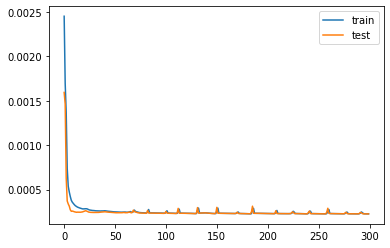

In [25]:
plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [26]:
from keras.models import load_model
model = load_model('best_model.h5')
yhat = model.predict(test_X)

In [33]:
y_2018 = test_Y * ratio
yhat_2018 = yhat * ratio

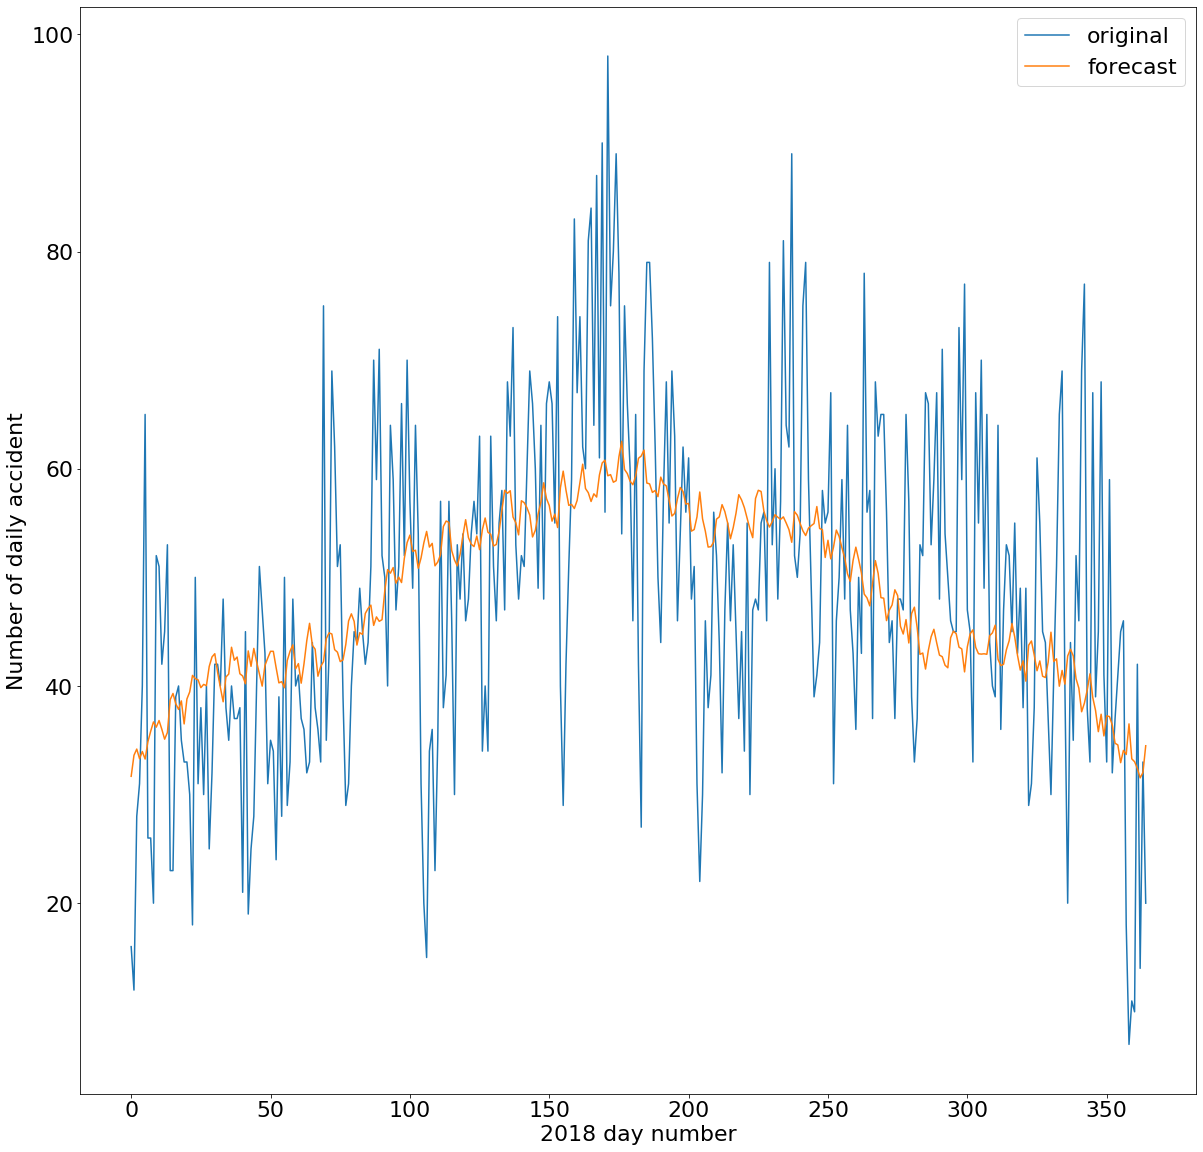

In [42]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}	
matplotlib.rc('font', **font)

plt.figure(figsize=(20, 20))
plt.plot(y_2018[0], label='original')
plt.plot(yhat_2018[0], label='forecast')
plt.ylabel('Number of daily accident')
plt.xlabel('2018 day number')
plt.legend()

In [35]:
def get_metrics(predicted, truth):
    error = truth - predicted
    percentage_error = 100 * error / (truth + 1E-20)
    rmse = np.sqrt(np.mean((error)**2))
    mae = np.mean(np.abs(error))
    mpse = np.mean(percentage_error)

    print('Root mean square error: {}'.format(rmse))
    print('Mean absolute error: {}'.format(mae))
    print('Mean percentage error: {}'.format(mpse))
    
get_metrics(yhat_2018, y_2018)

Root mean square error: 14.00768652824904
Mean absolute error: 10.880463231752996
Mean percentage error: -9.876400678180648
